# 고객 취향 군집화 실습

## **1. 환경 설정**

### 1.1 분석에 필요한 library 호출

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans

google drive 연결
from google.colab import drive
drive.mount('/content/drive')

## **2. 데이터 불러오기**

### 2.1 데이터 불러오기 및 확인

In [2]:
df_org = pd.read_csv('2019-Oct_purchase.csv')
df_org.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:02:14 UTC,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
1,2019-10-01 00:04:37 UTC,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
2,2019-10-01 00:06:02 UTC,purchase,5100816,2053013553375346967,NaN,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56
3,2019-10-01 00:07:07 UTC,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f
4,2019-10-01 00:09:26 UTC,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553


category_code : 대분류.중분류.소분류

In [3]:
df_org.tail()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
742844,2019-10-31 23:55:13 UTC,purchase,26402784,2053013563651392361,NaN,NaN,102.45,516604399,a98bd433-57ac-42d0-ba81-e18b135a7a16
742845,2019-10-31 23:55:21 UTC,purchase,47500017,2110937143172923797,construction.tools.light,puckator,20.59,514622109,5724116e-365b-4ac1-9d03-b8d66e1ccc7c
742846,2019-10-31 23:56:03 UTC,purchase,1003306,2053013555631882655,electronics.smartphone,apple,577.89,512717356,f35ac37c-9573-4e30-b3d9-c09bb0b95a2b
742847,2019-10-31 23:56:53 UTC,purchase,1004240,2053013555631882655,electronics.smartphone,apple,1054.60,533892594,3a5a3b01-2ab1-4a1d-a202-30d336e0057b
742848,2019-10-31 23:59:16 UTC,purchase,4804056,2053013554658804075,electronics.audio.headphone,apple,160.57,544501248,e330d051-37ad-4dc3-b1ee-ff16a28b7998


In [4]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742849 entries, 0 to 742848
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     742849 non-null  object 
 1   event_type     742849 non-null  object 
 2   product_id     742849 non-null  int64  
 3   category_id    742849 non-null  int64  
 4   category_code  569424 non-null  object 
 5   brand          684544 non-null  object 
 6   price          742849 non-null  float64
 7   user_id        742849 non-null  int64  
 8   user_session   742849 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 51.0+ MB


### 2.2 필요한 분석에 데이터 확인 및 선택




In [5]:
# event_type 별 값 확인 (원래 데이터는 view, cart,purchase로 이루워짐, 해당 데이터는 sampling 데이터라서 purchase 만 있음)
df_org['event_type'].value_counts()

purchase    742849
Name: event_type, dtype: int64

In [6]:
# 데이터 용량이 너무커서 필요한 구매 데이터만 사용하기로함
df_org = df_org[df_org.event_type =="purchase"]

## **3. NULL 값 처리**

### 3.1 NULL 값 확인

In [7]:
# Null 값이 있는 전체 case 수 확인
print(df_org.isnull().sum().sum())

231730


In [8]:
# df_org의 데이터 확인 (전체데이터 수, 변수의 개수)
df_org.shape

(742849, 9)

In [9]:
# Null 값의 비율
df_org.isnull().sum().sum() / df_org.shape[0]

0.3119476501953964

In [10]:
# Null 값이 있는 변수 확인 (null 값이 있는 컬럼이 2개 존재)

df_org.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code    173425
brand             58305
price                 0
user_id               0
user_session          0
dtype: int64

In [11]:
# 둘다 null 값인 항목확인 (38,388 건) : 두 정보 모두 없는 경우는 어떤 제품 구매했는지 확인 불가
df_org[(df_org.category_code.isnull()) & (df_org.brand.isnull())]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
13,2019-10-01 02:19:59 UTC,purchase,28100119,2053013564918072245,NaN,NaN,153.16,517953667,7954f58c-158d-402d-9820-c502a5eea86d
17,2019-10-01 02:20:28 UTC,purchase,26601440,2053013563517174627,NaN,NaN,91.12,554101070,5a29c401-c05b-4dcf-b9e6-78324875dfd4
21,2019-10-01 02:21:45 UTC,purchase,28100000,2053013564918072245,NaN,NaN,60.49,517953667,7954f58c-158d-402d-9820-c502a5eea86d
43,2019-10-01 02:26:02 UTC,purchase,34800175,2062461754293617058,NaN,NaN,33.46,512594464,f18609cf-7cab-47cf-aaf8-8622202722bd
67,2019-10-01 02:30:49 UTC,purchase,26012158,2053013562837697343,NaN,NaN,14.16,518446593,c0c4d86a-bf3c-4453-acfc-e69bd981d605
...,...,...,...,...,...,...,...,...,...
742827,2019-10-31 23:45:46 UTC,purchase,26500442,2053013563550729061,NaN,NaN,115.58,513911691,e6e67023-2258-4341-bd66-a9500d7da596
742840,2019-10-31 23:51:02 UTC,purchase,15600016,2053013559767466645,NaN,NaN,419.55,542728394,e62b779b-d70e-4468-8f35-4bcf6879e471
742841,2019-10-31 23:53:18 UTC,purchase,15600016,2053013559767466645,NaN,NaN,419.55,542728394,e62b779b-d70e-4468-8f35-4bcf6879e471
742843,2019-10-31 23:54:33 UTC,purchase,26205284,2053013563693335403,NaN,NaN,143.89,513040838,639dc99e-72cd-433d-ad90-24c78d71418f


In [12]:
# brand 값이 null 값인 건 확인 
df_org[df_org.brand.isnull()]
# 활용 가능할까? 어떤 제품을 구매했는지 모르더라도 카테고리 정보만 알수 있다면 활용할 수 있을것으로 판단됨. 단, 이번 실습에서는 제외 

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
13,2019-10-01 02:19:59 UTC,purchase,28100119,2053013564918072245,NaN,NaN,153.16,517953667,7954f58c-158d-402d-9820-c502a5eea86d
17,2019-10-01 02:20:28 UTC,purchase,26601440,2053013563517174627,NaN,NaN,91.12,554101070,5a29c401-c05b-4dcf-b9e6-78324875dfd4
21,2019-10-01 02:21:45 UTC,purchase,28100000,2053013564918072245,NaN,NaN,60.49,517953667,7954f58c-158d-402d-9820-c502a5eea86d
29,2019-10-01 02:23:03 UTC,purchase,19100075,2053013556227473861,construction.tools.saw,NaN,120.47,513484630,92bc0a54-4dab-4748-9a39-edbb4c760254
43,2019-10-01 02:26:02 UTC,purchase,34800175,2062461754293617058,NaN,NaN,33.46,512594464,f18609cf-7cab-47cf-aaf8-8622202722bd
...,...,...,...,...,...,...,...,...,...
742827,2019-10-31 23:45:46 UTC,purchase,26500442,2053013563550729061,NaN,NaN,115.58,513911691,e6e67023-2258-4341-bd66-a9500d7da596
742840,2019-10-31 23:51:02 UTC,purchase,15600016,2053013559767466645,NaN,NaN,419.55,542728394,e62b779b-d70e-4468-8f35-4bcf6879e471
742841,2019-10-31 23:53:18 UTC,purchase,15600016,2053013559767466645,NaN,NaN,419.55,542728394,e62b779b-d70e-4468-8f35-4bcf6879e471
742843,2019-10-31 23:54:33 UTC,purchase,26205284,2053013563693335403,NaN,NaN,143.89,513040838,639dc99e-72cd-433d-ad90-24c78d71418f



### 3.2 NULL 값 처리 (삭제) 및 확인

이후 브랜드명과 category 값을 기준으로 군집을 생성하고 확인하려고 함. 그렇기 때문에 두 값중 하나라도 null 값인 것은 삭제 

In [13]:
#Null 값 제거 (행 기준)
df_na_treat =  df_org.dropna(axis = 0)

In [14]:
#Null 값 제거 되었는지 확인
df_na_treat.isnull().sum().sum()

0

## **4. 데이터탐색 및 이상치 제거**

### 4.1 전체 데이터 확인 

In [15]:
# df_na_treat 전체 데이터 확인 (전체데이터 수, 변수의 개수)
df_na_treat.shape

(549507, 9)

In [16]:
# 연속형 변수의 분포 확인 
df_na_treat.describe()
# price를 제외한 나머지는 의미가 없음 

,product_id,category_id,price,user_id
count,5.495070e+05,5.495070e+05,549507.000000,5.495070e+05
mean,3.054594e+06,2.054518e+18,371.001168,5.363179e+08
std,5.111423e+06,1.258658e+16,370.971646,1.832481e+07
min,1.000978e+06,2.053014e+18,0.880000,3.031604e+08
25%,1.004767e+06,2.053014e+18,131.530000,5.171431e+08
50%,1.005100e+06,2.053014e+18,230.880000,5.365788e+08
75%,3.600937e+06,2.053014e+18,462.440000,5.545513e+08
max,6.050000e+07,2.173217e+18,2574.040000,5.662783e+08


In [17]:
# 변수 type 확인
df_na_treat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549507 entries, 0 to 742848
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     549507 non-null  object 
 1   event_type     549507 non-null  object 
 2   product_id     549507 non-null  int64  
 3   category_id    549507 non-null  int64  
 4   category_code  549507 non-null  object 
 5   brand          549507 non-null  object 
 6   price          549507 non-null  float64
 7   user_id        549507 non-null  int64  
 8   user_session   549507 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 41.9+ MB


### 4.2 카테고리 데이터 데이터 확인 및 파생

In [18]:
# 카테고리 정보확인(어떤카테고리가 많이 판매되는지)(고유값 확인 : value_counts())
df_na_treat.category_code.value_counts(normalize =True) # normalize : 전체 1 기준 각 카테고리의 비율
# smartphone 카테고리가 커서 의미 없기때문에, 브랜드까지 나누어서 봐야겠구나! 파악가능


electronics.smartphone         0.614323
electronics.audio.headphone    0.055393
electronics.video.tv           0.039213
electronics.clocks             0.030294
appliances.kitchen.washer      0.029224
                                 ...   
apparel.skirt                  0.000005
apparel.jeans                  0.000005
apparel.shorts                 0.000004
apparel.jumper                 0.000004
apparel.jacket                 0.000002
Name: category_code, Length: 120, dtype: float64

In [19]:
# 카테고리 파싱 (카테고리 단위별로 변수화)
## 카테고리 텍스트로 들어오고 있으나 값이 "."을 기준으로 구분되어있기에 파싱 필요!
df_na_treat[['ctgr_lv1','ctgr_lv2','ctgr_lv3','ctgr_lv4']] = df_na_treat['category_code'].str.split('.',expand= True)
df_na_treat

C:\Users\Miyoung\AppData\Local\Temp\ipykernel_15868\1655125670.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na_treat[['ctgr_lv1','ctgr_lv2','ctgr_lv3','ctgr_lv4']] = df_na_treat['category_code'].str.split('.',expand= True)
C:\Users\Miyoung\AppData\Local\Temp\ipykernel_15868\1655125670.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na_treat[['ctgr_lv1','ctgr_lv2','ctgr_lv3','ctgr_lv4']] = df_na_treat['category_code'].str.split('.',expand= True)
C:\Users\Miyoung\AppData\Local\Temp\ipykernel_

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,ctgr_lv1,ctgr_lv2,ctgr_lv3,ctgr_lv4
0,2019-10-01 00:02:14 UTC,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,electronics,smartphone,None,None
1,2019-10-01 00:04:37 UTC,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics,smartphone,None,None
3,2019-10-01 00:07:07 UTC,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,furniture,bathroom,toilet,None
4,2019-10-01 00:09:26 UTC,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,electronics,audio,headphone,None
5,2019-10-01 00:09:54 UTC,purchase,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics,audio,headphone,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
742842,2019-10-31 23:53:53 UTC,purchase,1004767,2053013555631882655,electronics.smartphone,samsung,242.63,542774966,957dc70c-31d3-42b7-aef0-2d2827c35251,electronics,smartphone,None,None
742845,2019-10-31 23:55:21 UTC,purchase,47500017,2110937143172923797,construction.tools.light,puckator,20.59,514622109,5724116e-365b-4ac1-9d03-b8d66e1ccc7c,construction,tools,light,None
742846,2019-10-31 23:56:03 UTC,purchase,1003306,2053013555631882655,electronics.smartphone,apple,577.89,512717356,f35ac37c-9573-4e30-b3d9-c09bb0b95a2b,electronics,smartphone,None,None
742847,2019-10-31 23:56:53 UTC,purchase,1004240,2053013555631882655,electronics.smartphone,apple,1054.60,533892594,3a5a3b01-2ab1-4a1d-a202-30d336e0057b,electronics,smartphone,None,None


In [20]:
# 대카테고리 값과 비율 확인
pd.concat([df_na_treat['ctgr_lv1'].value_counts(),df_na_treat['ctgr_lv1'].value_counts(normalize =True) ], axis = 1)
#normalize =  True : 비율
#axis = 1 : 행기준으로 나열

## 전자제품과 생활가전이 전체 약 90% 를 차지함

,ctgr_lv1,ctgr_lv1
electronics,420361,0.764978
appliances,71231,0.129627
computers,27151,0.049410
auto,7869,0.014320
apparel,6152,0.011195
construction,5439,0.009898
kids,4529,0.008242
furniture,3828,0.006966
accessories,1432,0.002606
sport,1029,0.001873


In [21]:
# 대카테고리 'electronics' 에 어떤 카테고리가 있을지 값 확인 
pd.concat([df_na_treat.loc[df_na_treat.ctgr_lv1 =="electronics",['ctgr_lv2']].value_counts(),
          df_na_treat.loc[df_na_treat.ctgr_lv1 =="electronics",['ctgr_lv2']].value_counts(normalize=True)], axis= 1)

## 스마트 폰은 비율이 너무 크기 때문에 브랜드로 나눠서 분석이 가능할 것으로 판단됨.
## 스마트 폰을 제외한 나머지를 하나의 카테고리로 묶어서 보기로 함.

,0,1
ctgr_lv2,,
smartphone,337575,0.803060
audio,34653,0.082436
video,21630,0.051456
clocks,16647,0.039602
tablet,5599,0.013320
telephone,3733,0.008880
camera,524,0.001247


In [22]:
# 대카테고리 'electronics.smartphone' 값 확인 
pd.concat([df_na_treat.loc[(df_na_treat.ctgr_lv1 =="electronics")&(df_na_treat.ctgr_lv2 =="smartphone") ,['brand']].value_counts(), 
df_na_treat.loc[(df_na_treat.ctgr_lv1 =="electronics")&(df_na_treat.ctgr_lv2 =="smartphone") ,['brand']].value_counts(normalize=True)], axis = 1)

## 전자제품의 스마트폰  카테고리는 비율이 크기 때문에 brand 단위로 봐도 일정 비율이 나올것 같음.
## 스마트폰 브랜드를 본결과 삼성,애플,기타 안드로이드폰으로 분류 (4:3:2로 나눔)

,0,1
brand,,
samsung,143123,0.423974
apple,115345,0.341687
xiaomi,38776,0.114866
huawei,21882,0.064821
oppo,10891,0.032262
vivo,2025,0.005999
meizu,1686,0.004994
honor,555,0.001644
nokia,512,0.001517


In [23]:
# 대카테고리 'appliances' 값 확인 
pd.concat([df_na_treat.loc[df_na_treat.ctgr_lv1 =="appliances",['ctgr_lv2']].value_counts(),
          df_na_treat.loc[df_na_treat.ctgr_lv1 =="appliances",['ctgr_lv2']].value_counts(normalize=True)], axis= 1)
## appliances 는 중카테고리의 수가 작아(12%) appliances 단일로 분석하는것이 좋을것으로 판단됨

,0,1
ctgr_lv2,,
kitchen,45057,0.632548
environment,17437,0.244795
iron,3647,0.051200
personal,2493,0.034999
sewing_machine,1939,0.027221
ironing_board,658,0.009238


### 4.3 트랜잭션 단위 데이터 -> 유저단위 데이터로  변경 (각 row 별 다른 유저 정보로 )

In [24]:
# 유저별 구매 카운트 확인, 전략 카테고리 생성 
user_by_ctgr_cnt = df_na_treat.groupby('user_id').agg(
    pur_cnt = ('event_time', 'count')
   , cash_sum = ('price', 'sum')
)
user_by_ctgr_cnt

,pur_cnt,cash_sum
user_id,,
303160429,1,340.59
340041246,1,339.70
384989212,1,41.44
401021311,1,231.64
403013066,2,807.16
...,...,...
566265448,1,592.01
566267483,2,30.74
566270060,2,147.42


In [25]:
# 유저별 전략 카테고리 값 요약 
# smartphone = (카테고리1 = electronics & 카테고리2 = smartphone & brand = 삼성, 애플, 기타 )
# appliceancs = appliances 
# ect  = 카테고리가 electronics 도 아니고, appliances 도 아닌 나머지 
smartphone_samsung =  df_na_treat[(df_na_treat.ctgr_lv1 == 'electronics') & (df_na_treat.ctgr_lv2 == 'smartphone') & (df_na_treat.brand == 'samsung')].groupby('user_id')['brand'].count()
smartphone_apple =  df_na_treat[(df_na_treat.ctgr_lv1 == 'electronics') & (df_na_treat.ctgr_lv2 == 'smartphone') & (df_na_treat.brand == 'apple')].groupby('user_id')['brand'].count()
smartphone_ect =  df_na_treat[(df_na_treat.ctgr_lv1 == 'electronics') & (df_na_treat.ctgr_lv2 == 'smartphone') & ~(df_na_treat.brand == 'samsung') & ~(df_na_treat.brand == 'apple')].groupby('user_id')['brand'].count()
electronics = df_na_treat[(df_na_treat.ctgr_lv1 == 'electronics') & ~(df_na_treat.ctgr_lv2 == 'smartphone')].groupby('user_id')['brand'].count()
appliances = df_na_treat[(df_na_treat.ctgr_lv1 == 'appliances')].groupby('user_id')['brand'].count()
ect = df_na_treat[~((df_na_treat.ctgr_lv1 == 'electronics') | (df_na_treat.ctgr_lv1 == 'appliances'))].groupby('user_id')['brand'].count()

In [26]:
smartphone_apple.head() # 시리즈 형태

user_id
403013066    1
410333972    1
444316141    1
451868425    1
453908841    1
Name: brand, dtype: int64

In [27]:
# series 를 data frame 변경 및 카테고리 명 변경 

smartphone_samsung = smartphone_samsung.to_frame().reset_index().rename(columns = {'brand':'smartphone_samsung'})
smartphone_apple = smartphone_apple.to_frame().reset_index().rename(columns = {'brand': 'smartphone_apple'})
smartphone_ect = smartphone_ect.to_frame().reset_index().rename(columns = {'brand' : 'smartphone_ect'})
electronics = electronics.to_frame().reset_index().rename(columns = {'brand': 'electronics'})
appliances = appliances.to_frame().reset_index().rename(columns ={'brand' : 'appliances'})
ect = ect.to_frame().reset_index().rename(columns = {'brand' :'etc'})


In [28]:
smartphone_samsung #예시

,user_id,smartphone_samsung
0,403013066,1
1,415873351,2
2,424869855,1
3,427391662,1
4,430524990,1
...,...,...
76519,566254545,1
76520,566256165,1
76521,566258816,1
76522,566263549,1


In [29]:
# 데이터 통합 
user_by_ctgr_cnt = pd.merge(user_by_ctgr_cnt,smartphone_samsung, how ='left', on = 'user_id' )
user_by_ctgr_cnt = pd.merge(user_by_ctgr_cnt,smartphone_apple, how ='left', on = 'user_id' )
user_by_ctgr_cnt = pd.merge(user_by_ctgr_cnt,smartphone_ect, how ='left', on = 'user_id' )
user_by_ctgr_cnt = pd.merge(user_by_ctgr_cnt,electronics, how ='left', on = 'user_id' )
user_by_ctgr_cnt = pd.merge(user_by_ctgr_cnt,appliances, how ='left', on = 'user_id' )
user_by_ctgr_cnt = pd.merge(user_by_ctgr_cnt,ect, how ='left', on = 'user_id' )
user_by_ctgr_cnt.fillna(0,inplace= True)
user_by_ctgr_cnt.head()

,user_id,pur_cnt,cash_sum,smartphone_samsung,smartphone_apple,smartphone_ect,electronics,appliances,etc
0,303160429,1,340.59,0.0,0.0,0.0,1.0,0.0,0.0
1,340041246,1,339.70,0.0,0.0,0.0,1.0,0.0,0.0
2,384989212,1,41.44,0.0,0.0,0.0,0.0,1.0,0.0
3,401021311,1,231.64,0.0,0.0,0.0,1.0,0.0,0.0
4,403013066,2,807.16,1.0,1.0,0.0,0.0,0.0,0.0


### 4.4 이상치 확인 

In [30]:
# 연속형 변수 분포 확인 
user_by_ctgr_cnt.describe()

## max 값에 극단값이 있는것이 보임

,user_id,pur_cnt,cash_sum,smartphone_samsung,smartphone_apple,smartphone_ect,electronics,appliances,etc
count,2.634450e+05,263445.000000,263445.000000,263445.000000,263445.000000,263445.000000,263445.000000,263445.000000,263445.000000
mean,5.366641e+08,2.085851,773.853133,0.543275,0.437833,0.300279,0.314244,0.270383,0.219837
std,1.855121e+07,3.618213,2291.897206,1.889915,1.894715,1.178621,1.298420,0.914654,0.914932
min,3.031604e+08,1.000000,0.880000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.175192e+08,1.000000,145.430000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.365856e+08,1.000000,287.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.555559e+08,2.000000,738.740000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.662783e+08,322.000000,265569.520000,192.000000,183.000000,154.000000,272.000000,71.000000,65.000000


In [31]:
# 이상치 케이스 확인

user_by_ctgr_cnt[user_by_ctgr_cnt['pur_cnt']>= 100]
## 이상치의 경우 포함 or 미포함에 대한 장/단점 확인해서 생각해보기
## 만약 개인 취향 분석이 목적이라면 미포함을 하는게 맞음
## 몇개 이상을 이상치로 할 것인지 생각해보기 

,user_id,pur_cnt,cash_sum,smartphone_samsung,smartphone_apple,smartphone_ect,electronics,appliances,etc
893,512386086,322,182470.80,105.0,67.0,1.0,87.0,61.0,1.0
3896,512511358,110,91994.91,0.0,106.0,0.0,0.0,2.0,2.0
15991,513117637,183,244282.74,0.0,183.0,0.0,0.0,0.0,0.0
19608,513320236,242,94568.05,135.0,36.0,0.0,68.0,3.0,0.0
19654,513322839,146,40752.12,101.0,0.0,4.0,6.0,13.0,22.0
26706,513784794,126,143821.03,0.0,4.0,0.0,118.0,0.0,4.0
46995,515384420,122,210749.77,0.0,122.0,0.0,0.0,0.0,0.0
55778,516214275,113,11263.07,101.0,0.0,12.0,0.0,0.0,0.0
67388,517728689,178,42201.92,171.0,0.0,7.0,0.0,0.0,0.0
76875,518957516,110,42968.98,0.0,1.0,0.0,78.0,31.0,0.0


Text(0.5, 0, 'pur_cnt')

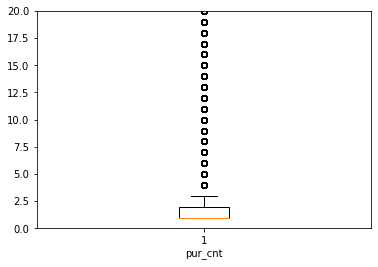

In [32]:
# box plot 으로 시각화 
fig, ax = plt.subplots()
ax.boxplot(user_by_ctgr_cnt['pur_cnt'])
ax.set_ylim (0,20) # y 축 limit 
ax.set_xlabel('pur_cnt')

### 4.5 이상치 기준 정의 

In [33]:
# 이상치 판단 기준 

user_by_ctgr_cnt[user_by_ctgr_cnt['pur_cnt']>= 50]['user_id'].count()

print("표준편차 :", user_by_ctgr_cnt['pur_cnt'].std())
print("99분위수 :", user_by_ctgr_cnt['pur_cnt'].quantile(q =0.99), ", 대상자수 : ",user_by_ctgr_cnt[user_by_ctgr_cnt['pur_cnt']>= 14]['user_id'].count()) # 상위 1%
print("3시그마 :", (user_by_ctgr_cnt['pur_cnt'].mean()) + (user_by_ctgr_cnt['pur_cnt'].std()*3), ", 대상자수 : ",user_by_ctgr_cnt[user_by_ctgr_cnt['pur_cnt']>= 13]['user_id'].count())# 0.05% 정도에 해당되는 값
print("6시그마 :", (user_by_ctgr_cnt['pur_cnt'].mean()) + (user_by_ctgr_cnt['pur_cnt'].std()*6), ", 대상자수 : ",user_by_ctgr_cnt[user_by_ctgr_cnt['pur_cnt']>= 23]['user_id'].count())# 0.001% 정도에 해당되는 값
# 99분위수 확인  14  (14개 이상은 주문은 이상치로 간주하기로함)
## 혹은 1개, 2개 , 3개 등등 구매한 사람들 각 count 해서 갑자기 뚝떨어지는 지점으로 해도 괜찮음 

표준편차 : 3.618212644021231
99분위수 : 14.0 , 대상자수 :  3013
3시그마 : 12.940488868691833 , 대상자수 :  3478
6시그마 : 23.795126800755526 , 대상자수 :  1115


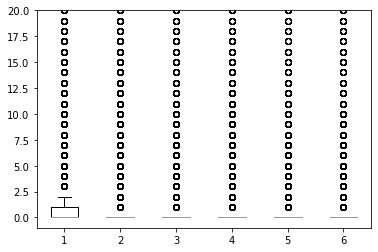

In [34]:
fig, ax = plt.subplots()
ax.boxplot([user_by_ctgr_cnt['smartphone_samsung'], user_by_ctgr_cnt['smartphone_apple'], user_by_ctgr_cnt['smartphone_ect'], user_by_ctgr_cnt['electronics'], user_by_ctgr_cnt['appliances'],user_by_ctgr_cnt['etc']])
ax.set_ylim (-1,20)
plt.show()

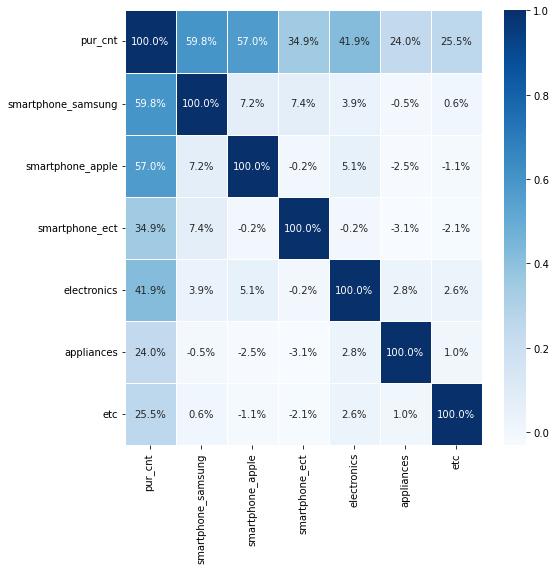

In [35]:
# 각 변수별 상관관계 확인 
plt.figure(figsize =(8,8))
sns.heatmap(data = user_by_ctgr_cnt[['pur_cnt','smartphone_samsung','smartphone_apple','smartphone_ect','electronics','appliances','etc']].corr(),annot= True,
            fmt ='.1%', linewidths =.5, cmap='Blues')
plt.show()

## 각 브랜드별 상관관계가 거의 없음
## 구매건수와 다른 변수간 연관성이 가장 큼. 그외는 거의 독립적임

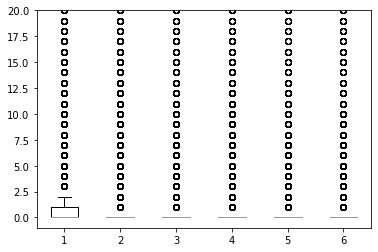

In [36]:
# 각 전략 카테고리별 구매건수 확인 
fig, ax = plt.subplots()
ax.boxplot([user_by_ctgr_cnt['smartphone_samsung'], user_by_ctgr_cnt['smartphone_apple'], user_by_ctgr_cnt['smartphone_ect'], user_by_ctgr_cnt['electronics'], user_by_ctgr_cnt['appliances'],user_by_ctgr_cnt['etc']])
ax.set_ylim (-1,20)
plt.show()

In [37]:
# 이상치 제거 
##pur_cnt max = 13 로 설정 !
df_train_data = user_by_ctgr_cnt[(user_by_ctgr_cnt.pur_cnt < 14)]
print(df_train_data.shape)
df_train_data.describe()

(260432, 9)


,user_id,pur_cnt,cash_sum,smartphone_samsung,smartphone_apple,smartphone_ect,electronics,appliances,etc
count,2.604320e+05,260432.000000,260432.000000,260432.000000,260432.000000,260432.000000,260432.000000,260432.000000,260432.000000
mean,5.366739e+08,1.817841,648.340886,0.464601,0.356784,0.266023,0.277366,0.253828,0.199238
std,1.855710e+07,1.659568,1082.946279,1.022210,1.002537,0.768920,0.781203,0.697226,0.653681
min,3.031604e+08,1.000000,0.880000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.175314e+08,1.000000,143.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.365809e+08,1.000000,285.440000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.555716e+08,2.000000,725.120000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.662783e+08,13.000000,28723.760000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000


## **5. 군집화**

### 5.1 변수의 표준화

In [38]:
df_train_data = df_train_data.reset_index()

In [40]:
df_train_data.head()

,index,user_id,pur_cnt,cash_sum,smartphone_samsung,smartphone_apple,smartphone_ect,electronics,appliances,etc
0,0,303160429,1,340.59,0.0,0.0,0.0,1.0,0.0,0.0
1,1,340041246,1,339.70,0.0,0.0,0.0,1.0,0.0,0.0
2,2,384989212,1,41.44,0.0,0.0,0.0,0.0,1.0,0.0
3,3,401021311,1,231.64,0.0,0.0,0.0,1.0,0.0,0.0
4,4,403013066,2,807.16,1.0,1.0,0.0,0.0,0.0,0.0


In [39]:
# 변수 표준화 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_train_data.iloc[:,2:])# iloc(행, 열) # 열에서 index, user_id 제외함
np_train_scaled = scaler.transform(df_train_data.iloc[:,2:]) #numpy로 저장됨
np_train_scaled

array([[-0.4928045 , -0.28417982, -0.45450754, ...,  0.92502851,
        -0.36405533, -0.30479472],
       [-0.4928045 , -0.28500165, -0.45450754, ...,  0.92502851,
        -0.36405533, -0.30479472],
       [-0.4928045 , -0.5604175 , -0.45450754, ..., -0.35505048,
         1.07020317, -0.30479472],
       ...,
       [ 0.10976302, -0.46255466,  0.52376719, ..., -0.35505048,
         1.07020317, -0.30479472],
       [-0.4928045 ,  1.25887291, -0.45450754, ..., -0.35505048,
        -0.36405533, -0.30479472],
       [-0.4928045 ,  0.93518125, -0.45450754, ..., -0.35505048,
        -0.36405533, -0.30479472]])

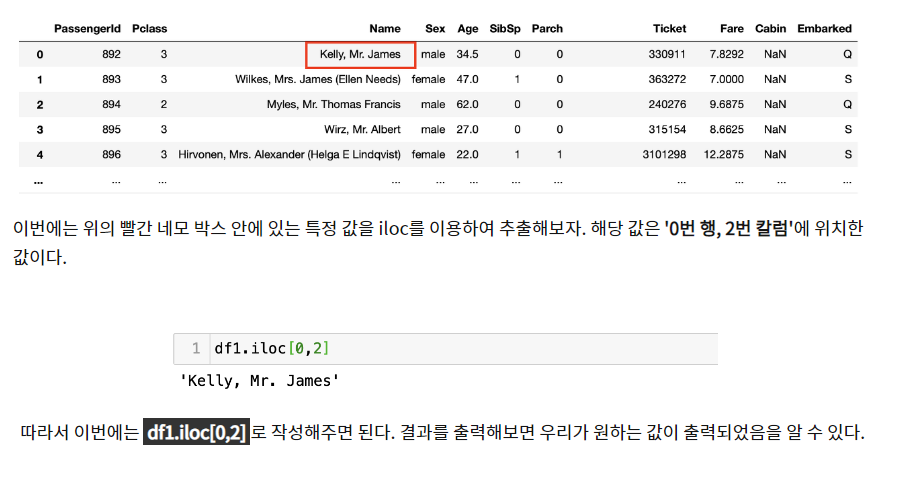 [참고] https://bigdaheta.tistory.com/42

### 5.2 군집화 알고리즘 적용 (k-means clustering)

In [41]:
kmeans = KMeans(n_clusters=5) #k의 디폴트값 = 5
y_pred = kmeans.fit_predict(np_train_scaled)
kmeans.cluster_centers_

array([[-0.09855815, -0.30473221, -0.39393697, -0.32416272, -0.29467513,
        -0.29655404,  1.66765048, -0.21473889],
       [-0.29748661, -0.16379694, -0.04271797, -0.08932395, -0.01406563,
        -0.13598932, -0.36400901,  0.01585651],
       [ 2.62102302,  0.93590767,  2.68488906, -0.10705419,  1.82067616,
        -0.12052337, -0.11888515,  0.74908332],
       [ 2.28752637,  3.82895794, -0.11051624,  4.30866659, -0.21371654,
        -0.05805431, -0.21855861, -0.07382033],
       [ 1.05119351,  0.23252432, -0.31129183, -0.22311525, -0.24931533,
         3.46154066, -0.22613872, -0.10460673]])

In [42]:
# 최적의 cluster 개수 찾기

kmeans_per_k = [KMeans(n_clusters=k).fit(np_train_scaled) for k in range(1, 11)]
inertias = [model.inertia_ for model in kmeans_per_k]


In [44]:
inertias #분산만

[2083456.0000000007,
 1683527.7941451464,
 1501218.5782485565,
 1354598.4435333475,
 1209471.3521978874,
 1081759.3172017094,
 947084.0878325775,
 868746.3758873498,
 764126.4907042325,
 690854.237560422]

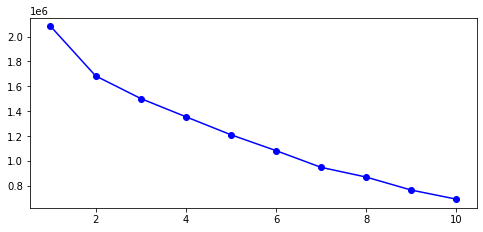

In [43]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 11), inertias, "bo-")
#plt.axis([1, 8.5, 0, 1300])
plt.show()

In [ ]:
# silhouette_score (가능하면 pass, 오래걸림)

# from sklearn.metrics import silhouette_score
# silhouette_score(np_train_scaled, kmeans.labels_)

### 5.3 8개 군집생성 및 군집별 특성확인

In [45]:
# 8개 군집
kmeans = KMeans(n_clusters=8, random_state = 1111) # random_state 지정 해야 결과를 고정시켜주는 시드값 (재연성을 위함)(숫자는 랜덤으로 지정하면됨)
y_pred = kmeans.fit_predict(np_train_scaled)
kmeans.cluster_centers_
y_pred

array([3, 3, 2, ..., 2, 0, 0])

In [52]:
pd.DataFrame(y_pred)
#pd.concat(df_train_data, pd.DataFrame(y_pred))
df_train_data['clst_k8'] = pd.Series(y_pred) # clst_k8 = 군집
df_train_data.head()


,index,user_id,pur_cnt,cash_sum,smartphone_samsung,smartphone_apple,smartphone_ect,electronics,appliances,etc,clst_k8
0,0,303160429,1,340.59,0.0,0.0,0.0,1.0,0.0,0.0,3
1,1,340041246,1,339.70,0.0,0.0,0.0,1.0,0.0,0.0,3
2,2,384989212,1,41.44,0.0,0.0,0.0,0.0,1.0,0.0,2
3,3,401021311,1,231.64,0.0,0.0,0.0,1.0,0.0,0.0,3
4,4,403013066,2,807.16,1.0,1.0,0.0,0.0,0.0,0.0,0


In [53]:
# 각 군집별 비율 확인하기
round(df_train_data.groupby('clst_k8').user_id.count()/df_train_data.shape[0],3)

clst_k8
0    0.163
1    0.036
2    0.162
3    0.434
4    0.018
5    0.044
6    0.019
7    0.124
Name: user_id, dtype: float64

In [54]:
# 8개 클러스터 EDA
df_train_data.groupby('clst_k8').agg(
    uu = ('user_id','count'),
    avg_pur_cnt = ('pur_cnt','mean'),
    smartphone_samsung_avg = ('smartphone_samsung','mean'),
    smartphone_apple_avg = ('smartphone_apple','mean'),
    smartphone_ect_avg = ('smartphone_ect','mean'),
    electronics_avg = ('electronics','mean'),
    appliances_avg = ('appliances','mean'),
    etc_avg = ('etc','mean')
)
# + 군집비율 붙이기 

,uu,avg_pur_cnt,smartphone_samsung_avg,smartphone_apple_avg,smartphone_ect_avg,electronics_avg,appliances_avg,etc_avg
clst_k8,,,,,,,,
0,42522,1.600560,0.105428,1.390527,0.033089,0.048634,0.011500,0.011382
1,9504,5.138889,4.361953,0.223906,0.200337,0.132050,0.126157,0.094487
2,42160,1.606499,0.060176,0.019877,0.035816,0.044355,1.431333,0.014943
3,112923,1.190882,0.573453,0.001151,0.362247,0.253854,0.000177,0.000000
4,4791,6.900230,0.436026,5.718430,0.109372,0.308704,0.132540,0.195158
5,11462,3.549032,0.143430,0.148578,0.065172,2.988571,0.099983,0.103298
6,4878,5.185732,0.396269,0.133456,4.313448,0.144731,0.098811,0.099016
7,32192,1.717290,0.065203,0.029293,0.038581,0.060139,0.055573,1.468501


- 0 군집 - 생활가전을 소량 구매 유저(16.3%)
- 1 군집 - 애플폰 다회(충성) 구매 유저 (3.6%)
- 2 군집 - 전자제품 (핸드폰 및 소형 가전제품) 단건 구매 유저(16.2%) 
- 3 군집 - 기타 상품 소회 구매 유저 (43.3%)
- 4 군집 - 스마트폰을 제외한 소형 가전제품 다회 구매 유저 (1.8%)
- 5 군집 - 생활가전 다회 구매하며 삼성폰을 간간히 구매 유저 (4.4%)
- 6 군집 - 기타 스마트폰 다회 구매 유저 (1.9%)
- 7 군집 - 삼성폰을 다회(충성) 구매 유저 (1.2%)

### 5.4 4개 군집생성 및 군집별 특성확인

In [46]:
# 4개 군집
kmeans = KMeans(n_clusters=4, random_state= 1111)
y_pred = kmeans.fit_predict(np_train_scaled)
kmeans.cluster_centers_
y_pred
df_train_data['clst_k4'] = pd.Series(y_pred)

In [47]:
# 각 군집별 비율 확인하기
df_train_data.groupby('clst_k4').user_id.count()/df_train_data.shape[0]

clst_k4
0    0.041619
1    0.868127
2    0.058937
3    0.031317
Name: user_id, dtype: float64

In [48]:
# 8개 클러스터 EDA
df_train_data.groupby('clst_k4').agg(
    uu = ('user_id','count'),
    avg_pur_cnt = ('pur_cnt','mean'),
    smartphone_samsung_avg = ('smartphone_samsung','mean'),
    smartphone_apple_avg = ('smartphone_apple','mean'),
    smartphone_ect_avg = ('smartphone_ect','mean'),
    electronics_avg = ('electronics','mean'),
    appliances_avg = ('appliances','mean'),
    etc_avg = ('etc','mean')
)

,uu,avg_pur_cnt,smartphone_samsung_avg,smartphone_apple_avg,smartphone_ect_avg,electronics_avg,appliances_avg,etc_avg
clst_k4,,,,,,,,
0,10839,3.213581,0.118000,0.053695,0.063105,0.118738,2.762801,0.097241
1,226088,1.332163,0.352849,0.223612,0.213567,0.220065,0.149035,0.173034
2,15349,5.975568,2.409277,0.247834,1.268747,1.236823,0.119291,0.693596
3,8156,5.601643,0.363291,4.656204,0.102746,0.270966,0.077612,0.130824


- 0 군집 - 생활 가전 단건 구매 유저 (4.1%)
- 1 군집 - 스마트폰 다회 구매 유저 (애플과 삼성 스마트폰 중심) (86.8%)
- 2 군집 - 전자제품이 아닌 기타 제품 단건 구매 유저 (5.8%)
- 3 군집 - 휴대폰 및 소형가전만 단건 구매 유저 (3.1%)





---



### 5.5 5개 군집생성 및 군집별 특성확인

- 군집이 커지면 각 카테고리별 구매한유저가 보임
- 군집이 작아지면 다중 카테고리 구매한 유저가 보임

- 전략적으로 카테고리 세분화 or 묶어주기
- 이상치 꼭 확인
- 군집 수 늘여보기 or 줄여보기
- 계속적인 반복 후에 군집 명명하고 의미 부여하기 !